In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
from mord import LogisticAT
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score
from yellowbrick.model_selection import LearningCurve
from kappa_loss_nn import KappaLossNN
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline
from skll.metrics import kappa
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize': (15.7, 8.27)})

In [10]:
# Ensure non-sklearn models have proper label
# Without this, automatic stratification doens't occur
from sklearn.base import is_classifier
LogisticAT._estimator_type = "classifier" # type: ignore
assert is_classifier(LogisticAT) 
assert is_classifier(KappaLossNN)
assert is_classifier(XGBClassifier)

In [3]:
df = pd.read_csv("./data/preprocessed_data.csv", index_col=0)

TARGET = "NSP"
FEATURES = df.columns.drop(TARGET)

# Reserve a "final final" test set
X = df[FEATURES].values
y = df[TARGET].values.astype(int) - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [4]:
# error metrics for each class of fetal state
f1Scorer1 = make_scorer(lambda x, y: f1_score(x, y, average=None)[0])
f1Scorer2 = make_scorer(lambda x, y: f1_score(x, y, average=None)[1])
f1Scorer3 = make_scorer(lambda x, y: f1_score(x, y, average=None)[2])
precScorer1 = make_scorer(lambda x, y: precision_score(x, y, average=None)[0])
precScorer2 = make_scorer(lambda x, y: precision_score(x, y, average=None)[1])
precScorer3 = make_scorer(lambda x, y: precision_score(x, y, average=None)[2])
recallScorer1 = make_scorer(lambda x, y: recall_score(x, y, average=None)[0])
recallScorer2 = make_scorer(lambda x, y: recall_score(x, y, average=None)[1])
recallScorer3 = make_scorer(lambda x, y: recall_score(x, y, average=None)[2])

# Penalties for different types of class confusion
weights = np.array([
# Predicted   N    S    P     # True
            [0.0, 0.5, 0.6],  # N
            [1.0, 0.0, 0.3],  # S
            [2.0, 0.6, 0.0]   # P
])
def weightedKappa(x, y): return kappa(x, y, weights=weights)

kappaScorer = make_scorer(weightedKappa)

complete_scorer = {
    'f1-N': f1Scorer1, 'f1-S': f1Scorer2, 'f1-P': f1Scorer3,
    'prec-N': precScorer1, 'prec-S': precScorer2, 'prec-P': precScorer3,
    'recall-N': recallScorer1, 'recall-S': recallScorer2, 'recall-P': recallScorer3,
    'weighted-kappa': kappaScorer
}

In [5]:
# class weight between None and "Balanced"
class_weight_intermediate = {0: 1, 1: 2, 2: 3}
class_weight_high = {0: 1, 1: 10, 2: 20}
model_params = {
    'logisticOVR': {
        'model__C': [1, 5, 10],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'logisticMN': {
        'model__C': [1, 5, 10],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'kappaNN': {
        'model__alpha': [0, .03, .02, .01],
        'model__hidden_layer_shapes': [[], [5], [5,5]]
    },
    'ordinal': {'model__alpha': [0, 0.5, 1, 2]},
    'RF': {
        'model__n_estimators': [1, 10, 20],
        'model__max_features': ['sqrt', None],
        'model__max_depth': [None, 5, 10, 20],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'rbfSVM': {
        'model__C': [1, 5, 10],
        'model__gamma': [0.001, 0.0001],
        'model__class_weight': ['balanced', None, class_weight_intermediate, class_weight_high]
    },
    'KNN': {'model__n_neighbors': [3, 7, 10],
            'model__weights': ['uniform', 'distance']},
    'XGBoost': {
        'model__n_estimators': [1, 10, 20],
        'model__max_depth': [None, 5, 10, 20],
    }
}

pipe_params = {
    'PCA': [None, PCA(), PCA(15), PCA(10), PCA(5)],
    'smote': [None, SMOTE()]
}

In [6]:
def make_pipeline(model):
    return Pipeline(steps=[
               ('smote', SMOTE()),
               ('scaler', StandardScaler()),
               ('PCA', PCA()),
               ('model', model)
           ])

def make_inner_kfold(pipeline, preprocessing_grid, model_grid):
    full_grid = {}
    full_grid.update(preprocessing_grid)
    full_grid.update(model_grid)
    return GridSearchCV(pipeline, param_grid=full_grid, cv=2, n_jobs=-1, 
                        scoring=kappaScorer)

models = {
    # "logisticOVR": LogisticRegression(
    #     max_iter=5000, multi_class='ovr'
    # ),
    # "logisticMN": LogisticRegression(
    #     max_iter=5000, multi_class='multinomial'
    # ),
    "kappaNN": KappaLossNN(
        num_classes=3, weight_matrix=weights, max_iter=5000
    ),
    # "ordinal": LogisticAT(),
    # "RF": RandomForestClassifier(),
    # "rbfSVM": svm.SVC(kernel="rbf"),
    # "KNN": KNeighborsClassifier(),
    # "XGBoost": XGBClassifier(
    #     use_label_encoder=False, eval_metric="mlogloss",
    # )
}

piped_models = {
    key: make_pipeline(model) 
    for key, model in models.items()
}

piped_folded_models = {
    key: make_inner_kfold(pipe, pipe_params, model_params[key])
    for key, pipe in piped_models.items()
}

In [7]:
scores = {}
for key, model in piped_folded_models.items():
    # Instantiate the classification model and visualizer
    scores[key] = cross_validate(
        model, X=X_train, y=y_train, 
        cv=5, scoring=complete_scorer, n_jobs=-1, verbose=10
        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................[CV] START .....................................................................

[CV] START .....................................................................


Stopping early after 165 iterations.
Stopping early after 163 iterations.
Stopping early after 163 iterations.
Stopping early after 177 iterations.
Stopping early after 221 iterations.
Stopping early after 231 iterations.
Stopping early after 221 iterations.
Stopping early after 248 iterations.
Stopping early after 247 iterations.
Stopping early after 257 iterations.
Stopping early after 266 iterations.
Stopping early after 267 iterations.
Stopping early after 274 iterations.
Stopping early after 282 iterations.
Stopping early after 271 iterations.
Stopping early after 285 iterations.
Stopping early after 309 iterations.
Stopping early after 316 iterations.
Stopping early after 323 iterations.
Stopping early after 323 iterations.
Stopping early after 344 iterations.
Stopping early after 349 iterations.Stopping early after 343 iterations.

Stopping early after 355 iterations.
Stopping early after 348 iterations.
Stopping early after 351 iterations.
Stopping early after 362 iterations.
S

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min


Stopping early after 346 iterations.
[CV] END  f1-N: (test=0.936) f1-P: (test=0.717) f1-S: (test=0.600) prec-N: (test=0.962) prec-P: (test=0.704) prec-S: (test=0.536) recall-N: (test=0.911) recall-P: (test=0.731) recall-S: (test=0.682) weighted-kappa: (test=0.762) total time= 4.8min


[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  4.9min remaining:  3.2min


Stopping early after 420 iterations.
Stopping early after 11 iterations.
Stopping early after 514 iterations.
Stopping early after 575 iterations.
Stopping early after 2783 iterations.
Stopping early after 11 iterations.
Stopping early after 1220 iterations.
Stopping early after 11 iterations.
Stopping early after 275 iterations.
Stopping early after 374 iterations.
Stopping early after 1409 iterations.
Stopping early after 313 iterations.
Stopping early after 322 iterations.
Stopping early after 1736 iterations.
Stopping early after 783 iterations.
Stopping early after 268 iterations.
Stopping early after 1136 iterations.
Stopping early after 2900 iterations.
Stopping early after 288 iterations.
Stopping early after 279 iterations.
Stopping early after 435 iterations.
Stopping early after 835 iterations.
Stopping early after 2204 iterations.
[CV] END  f1-N: (test=0.945) f1-P: (test=0.800) f1-S: (test=0.716) prec-N: (test=0.991) prec-P: (test=0.759) prec-S: (test=0.609) recall-N: (test

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


In [8]:
def ff(a):
    return np.mean(a) - np.std(a)
pd.DataFrame(scores).applymap(ff).T

,fit_time,score_time,test_f1-N,test_f1-P,test_f1-S,test_prec-N,test_prec-P,test_prec-S,test_recall-N,test_recall-P,test_recall-S,test_weighted-kappa
kappaNN,275.723018,0.236888,0.932868,0.740428,0.643209,0.959976,0.723765,0.556598,0.894488,0.751674,0.731923,0.765163


<AxesSubplot:xlabel='model', ylabel='test_weighted-kappa'>

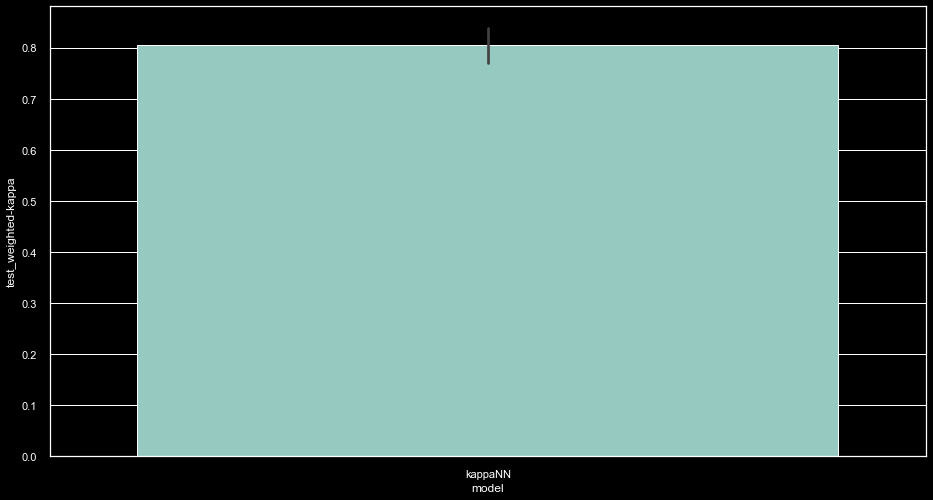

In [9]:
x = pd.concat([ pd.DataFrame(scores[key]).assign(model=key) for key in scores.keys()])
sns.barplot(x="model", y="test_weighted-kappa", data=x)

In [ ]:
def f(a):
    return np.mean(a) - np.std(a)
pd.DataFrame(scores).applymap(f).T

,fit_time,score_time,test_f1-N,test_f1-S,test_f1-P,test_prec-N,test_prec-S,test_prec-P,test_recall-N,test_recall-S,test_recall-P,test_weighted-kappa
logisticOVR,27.997537,0.010828,0.919192,0.617065,0.726648,0.960170,0.532585,0.637799,0.865669,0.694770,0.796522,0.752066
logisticMN,28.210552,0.009349,0.915181,0.580778,0.725801,0.960701,0.485635,0.671240,0.858159,0.680389,0.780240,0.743147
kappaPerceptron,43.817992,0.167996,0.873060,0.605103,0.657306,0.982798,0.475207,0.526437,0.784990,0.817518,0.818204,0.703126
ordinal,7.130449,0.009418,0.877241,0.448015,0.725096,0.930544,0.362325,0.669615,0.789825,0.522734,0.684625,0.658802
RF,104.211742,0.013534,0.954259,0.728370,0.859161,0.953877,0.731643,0.834584,0.951764,0.714059,0.861770,0.820309
rbfSVM,37.821143,0.045160,0.917812,0.624279,0.717475,0.961569,0.534995,0.645497,0.851979,0.715718,0.779592,0.752543
KNN,6.400133,0.025748,0.932114,0.676614,0.782818,0.957132,0.598245,0.729401,0.899209,0.737486,0.814731,0.774361
XGBoost,104.819473,0.017472,0.962572,0.772320,0.881912,0.960996,0.777340,0.859037,0.961329,0.761108,0.852453,0.846552
